In [0]:
import cv2
import os
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten,UpSampling2D
from keras import Input
from keras.applications import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras

In [0]:
x_train_hr=[]

In [0]:
t=100
c=0
x=y=0
for img in os.listdir('drive/My Drive/input'):
  c+=1
  idr=os.path.join('drive/My Drive/input/'+img)
  im=cv2.imread(idr)
  x+=im.shape[0]
  y+=im.shape[1]
  x_train_hr.append(im)

In [0]:
input_shape=(187,187,3)
output_shape=(748,748,3)

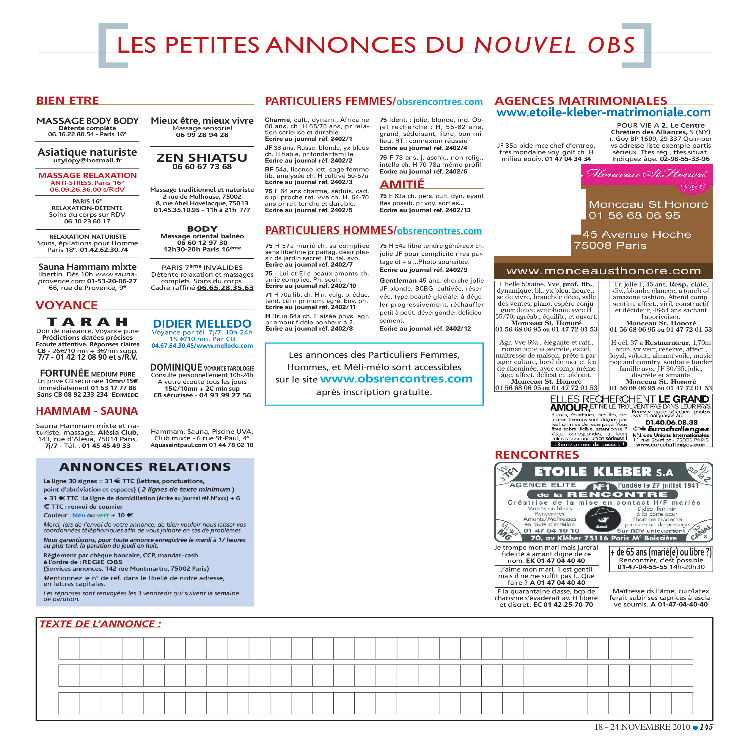

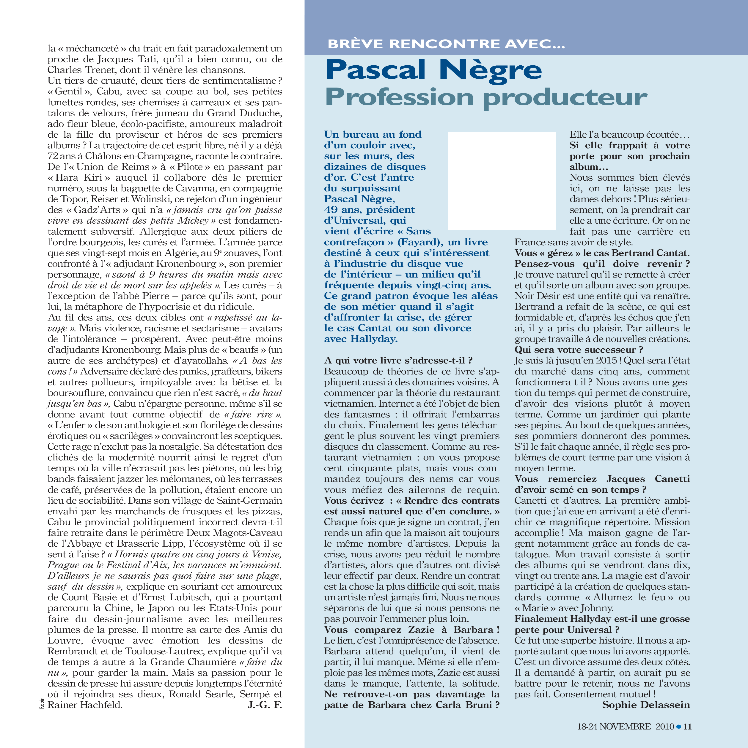

In [0]:
x=[]
c=0
for im in x_train_hr:
  c+=1
  im=cv2.resize(im,(output_shape[0],output_shape[1]))
  x.append(im)
x_train_hr=x

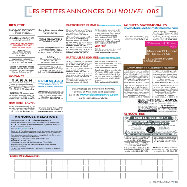

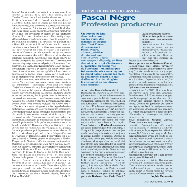

In [0]:
x_train_lr=[]
x=[]
c=0
for im in x_train_hr:
  c+=1
  im=cv2.resize(im,(input_shape[0],input_shape[1]))
  x.append(im)
x_train_lr=x

In [0]:
def normalize(input_data):

    return (input_data.astype(np.float32) - 127.5)/127.5 
    
def denormalize(input_data):
    input_data = (input_data + 1) * 127.5
    return input_data.astype(np.uint8)

In [0]:
x_train_hr=np.array(x_train_hr)
x_train_lr=np.array(x_train_lr)
x_train_hr=normalize(x_train_hr)
x_train_lr=normalize(x_train_lr)

In [0]:
common_optimizer = Adam(0.0002, 0.5)

In [0]:
def residual_block(X):
  #residual
  res=Conv2D(filters=64,kernel_size=(3,3),padding='same')(X)
  res=Activation(activation='relu')(res)
  res=BatchNormalization(momentum=0.8)(res)
  
  res=Conv2D(filters=64,kernel_size=(3,3),padding='same')(res)
  res=BatchNormalization(momentum=0.8)(res)
  #elementwise sum
  res=Add()([res,X])
  return res
  

In [0]:
def get_generator():
  #input layer
  input_layer = Input(shape=input_shape)

  #pre-residual block
  gen1=Conv2D(64,(9,9),padding='same')(input_layer)
  gen1=Activation(activation='relu')(gen1)
  
  #16 residual block
  res=residual_block(gen1)   
  for i in range(15):        
      res=residual_block(res)

  #post-residual block
  gen2 = Conv2D(64, kernel_size=3, padding='same')(res)
  gen2 = BatchNormalization(momentum=0.8)(gen2)

  #final element wise sum of pre residual block(gen1) and post residual block(gen2)
  gen=Add()([gen1,gen2])

  #upsampling block 1
  gen=UpSampling2D(size=(2,2))(gen)
  gen=Conv2D(256,(3,3),padding='same')(gen)
  gen=Activation(activation='relu')(gen)

  #upsampling block 2
  gen=UpSampling2D(size=(2,2))(gen)
  gen=Conv2D(256,(3,3),padding='same')(gen)
  gen=Activation(activation='relu')(gen)

  #final output with 3 filters which discribes rgb
  output_layer=Conv2D(3,(9,9),padding='same')(gen)
  output_layer=Activation('tanh')(output_layer)

  model=Model(inputs=[input_layer],outputs=[output_layer])
  return model

In [0]:
def get_discriminator():
  input_layer = Input(shape=output_shape)
  #input_layer = Lambda(normalize_m11)(input_layer)
  model=Conv2D(filters=64,kernel_size=(3,3),padding='same')(input_layer)
  model=LeakyReLU(alpha=0.2)(model)
  #block 1
  model=Conv2D(64,(3,3),strides=(2,2),padding='same')(model)
  model=BatchNormalization(momentum=0.8)(model)
  model=LeakyReLU(alpha=0.2)(model)
  #block 2
  model=Conv2D(128,(3,3),padding='same')(model)
  model=BatchNormalization(momentum=0.8)(model)
  model=LeakyReLU(alpha=0.2)(model)
  #block 3
  model=Conv2D(128,(3,3),strides=(2,2),padding='same')(model)
  model=BatchNormalization(momentum=0.8)(model)
  model=LeakyReLU(alpha=0.2)(model)
  #block 4
  model=Conv2D(256,(3,3),padding='same')(model)
  model=BatchNormalization(momentum=0.8)(model)
  model=LeakyReLU(alpha=0.2)(model)
  #block 5
  model=Conv2D(256,(3,3),strides=(2,2),padding='same')(model)
  model=BatchNormalization(momentum=0.8)(model)
  model=LeakyReLU(alpha=0.2)(model)
  #block 6
  model=Conv2D(512,(3,3),padding='same')(model)
  model=BatchNormalization(momentum=0.8)(model)
  model=LeakyReLU(alpha=0.2)(model)
  #block 7
  model=Conv2D(512,(3,3),strides=(2,2),padding='same')(model)
  model=BatchNormalization(momentum=0.8)(model)
  model=LeakyReLU(alpha=0.2)(model)

  model=Flatten()(model)
  model=Dense(units=128)(model)
  model=Dense(units=128)(model)
  model=Dense(units=256)(model)
  model=Dense(units=512)(model)
  model=LeakyReLU(alpha=0.2)(model)
  model=Dense(1)(model)
  model=Activation(activation='sigmoid')(model)

  model=Model([input_layer],[model])
  return model

In [0]:
def build_vgg():
    """
    Build VGG network to extract image features
    """
    input_layer = Input(shape=output_shape)
    # Load a pre-trained VGG19 model trained on 'Imagenet' dataset
    vgg = VGG19(weights="imagenet")
    vgg.outputs = [vgg.layers[9].output]
    # Extract features
    features = vgg(input_layer)
    # Create a Keras model
    model = Model(inputs=[input_layer], outputs=[features])
    return model

In [0]:
vgg = build_vgg()
vgg.trainable = False
vgg.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

In [0]:

# Build the generator network
generator = get_generator()

# Build and compile the discriminator
discriminator = get_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=common_optimizer, metrics=['accuracy'])

In [0]:
gan_input=Input(shape=input_shape)
generator_output=generator(gan_input)

discriminator.trainable=False

prob_output=discriminator(generator_output)
feature_output=vgg(generator_output)

adversarial_model=Model([gan_input],[prob_output,feature_output])
adversarial_model.compile(loss=['binary_crossentropy', 'mse'],loss_weights=[1e-3, 1],optimizer=common_optimizer)

In [0]:
for epoch in range(3000):
    print("Epoch:{}".format(epoch))
    rand_nums = np.random.randint(0, x_train_hr.shape[0], size=2)
  
    image_batch_hr = x_train_hr[rand_nums]
    image_batch_lr = x_train_lr[rand_nums]

    generator_output=generator.predict(image_batch_lr)
    
    discriminator.trainable=True

    real_labels = np.ones((2, 1))
    fake_labels = np.zeros((2, 1))

    d_loss_real = discriminator.train_on_batch(image_batch_hr, real_labels)
    d_loss_fake = discriminator.train_on_batch(generator_output, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    print("d_loss:", d_loss)

    rand_nums = np.random.randint(0, x_train_hr.shape[0], size=2)
    image_batch_hr = x_train_hr[rand_nums]
    image_batch_lr = x_train_lr[rand_nums]
    discriminator.trainable=False
    image_features = vgg.predict(image_batch_hr)
    g_loss = adversarial_model.train_on_batch([image_batch_lr],
                                              [real_labels, image_features])
    print("g_loss:", g_loss)

Streaming output truncated to the last 5000 lines.
g_loss: [8.068801, 60.60225, 8.008199]
Epoch:1334
d_loss: [4.160907e-14 1.000000e+00]
g_loss: [7.0700383, 40.571068, 7.029467]
Epoch:1335
d_loss: [5.9265304 0.75     ]
g_loss: [9.911505, 245.11649, 9.6663885]
Epoch:1336
d_loss: [0. 1.]
g_loss: [7.565929, 439.13977, 7.126789]
Epoch:1337
d_loss: [0. 1.]
g_loss: [11.497728, 519.8588, 10.97787]
Epoch:1338
d_loss: [0. 1.]
g_loss: [4.851066, 302.00278, 4.549063]
Epoch:1339
d_loss: [3.8257512e-04 1.0000000e+00]
g_loss: [13.816434, 643.97394, 13.17246]
Epoch:1340
d_loss: [0. 1.]
g_loss: [11.432432, 504.03812, 10.928394]
Epoch:1341
d_loss: [0. 1.]
g_loss: [7.815593, 472.1329, 7.34346]
Epoch:1342
d_loss: [0. 1.]
g_loss: [12.272099, 646.24915, 11.62585]
Epoch:1343
d_loss: [0. 1.]
g_loss: [11.226771, 549.18866, 10.677583]
Epoch:1344
d_loss: [0. 1.]
g_loss: [11.859099, 660.3889, 11.19871]
Epoch:1345
d_loss: [0. 1.]
g_loss: [8.789595, 404.13904, 8.385455]
Epoch:1346
d_loss: [0. 1.]
g_loss: [10.91382

In [0]:
x=cv2.imread('drive/My Drive/adr_b/adr_b2.jpg')
x=cv2.resize(x,(187,187))
x=x.reshape(-1,187,187,3)
x=normalize(x)
gen_im=generator.predict(x)

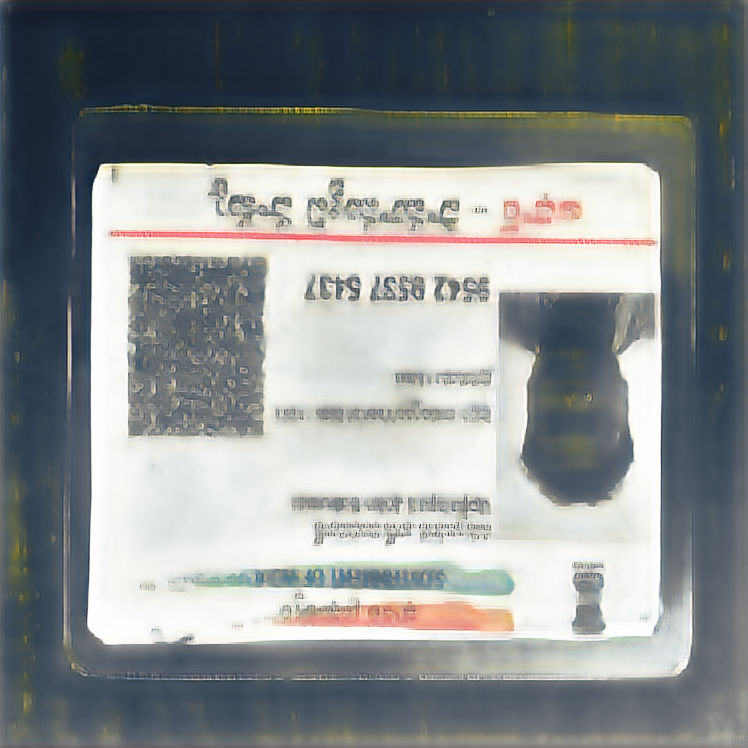

In [0]:
cv2_imshow(denormalize(gen_im[0]))

In [0]:
generator.save("srgan_generator_muhil.h5")